In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#             device = '/gpu:0'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-10-21 16:12:47.335463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-10-21 16:12:47.336913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-10-21 16:12:47.338362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


2024-10-21 16:12:32.015128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 16:12:32.103736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 16:12:32.140493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 16:12:32.152957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 16:12:32.223546: I tensorflow/core/platform/cpu_feature_guar

In [5]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [6]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 31, 
                transposed_midpoints_corrected[:, :, 1] * 31, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [31]:

from tensorflow.keras import layers, regularizers


class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=4, num_coordinates=2, learning_rate=1e-2, weights_path=None,l1_reg=0.001,l2_reg =0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)

    
        x_input = layers.Input(shape=self.input_shape)
        
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        # x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
        # # x = layers.MaxPool2D()(x)
        # # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [8]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/12KFixed_Mixed_13_32by32_SparsespotsRandomIndex.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


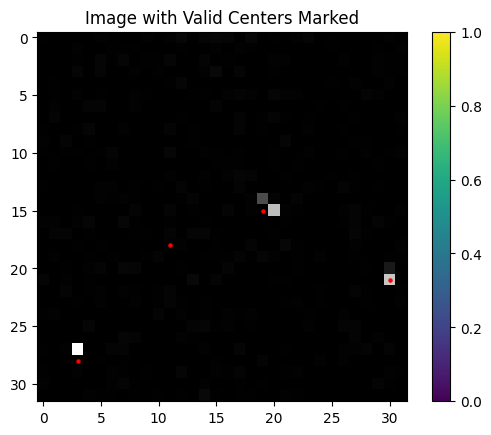

(<matplotlib.image.AxesImage at 0x7f40c45e5610>, 5819)

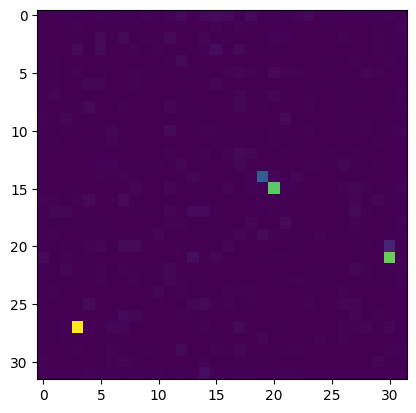

In [21]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

In [7]:
np.max(sorted_centers)

NameError: name 'sorted_centers' is not defined

(<matplotlib.image.AxesImage at 0x7f40c44766d0>, 5819)

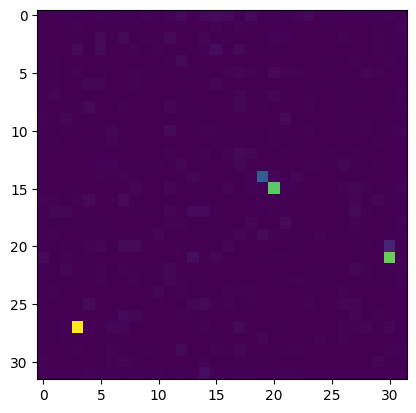

In [22]:
plt.imshow(images[l]),l

In [23]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1., 26., 11.],
       [ 1., 20., 26.],
       [ 1.,  7.,  8.],
       [ 1.,  9., 28.]], dtype=float32)

In [24]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [25]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.0, 1.0)

In [26]:
np.max(centers)

31.0

In [27]:

batch_size = 400
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (9600, 32, 32), Train Midpoints: (9600, 1, 4, 2)
Validation Images: (2400, 32, 32), Validation Midpoints: (2400, 1, 4, 2)


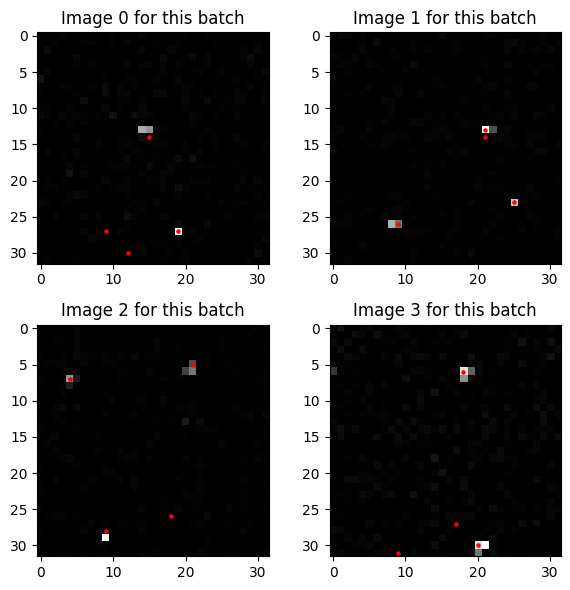

In [28]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [29]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=3e-6
)


In [32]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    # Instantiate the model builder
    # model_builder = ModelBuilder(weights_path= "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras")
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model using the custom loss function
    # model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(2))
    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
    
    # model_builder.compile_model(loss_function=custom_loss(3))e




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 8)              │         8,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 4, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,330,312 (39.41 MB)

 Trainable params: 10,329,800 (39.41 MB)

 Non-trainable params: 512 (2.00 KB)

In [33]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=1000,
    callbacks_list=[lr_scheduler]
)


Epoch 1/1000


2024-10-21 16:15:33.467946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-21 16:15:33.487722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-21 16:15:33.515430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729527333.634398   21418 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527333.635464   21398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527333.636307   21421 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527333.694458   21421 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527333.694460   21418 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527333.694655   21398 gpu_timer.c

 1/24 ━━━━━━━━━━━━━━━━━━━━ 4:15 11s/step - loss: 0.0979

W0000 00:00:1729527336.254888   21398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.255666   21398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.256602   21398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.256906   21416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.257376   21416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.257814   21416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.258006   21398 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.258286   21416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527336.258734   21416 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1607

2024-10-21 16:15:37.079641: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-21 16:15:37.079791: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-10-21 16:15:37.079911: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1729527337.642983   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527337.643691   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527337.647943   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be re

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.1595 - val_loss: 0.1124 - learning_rate: 0.0100
Epoch 2/1000


W0000 00:00:1729527338.655071   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.657511   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.660739   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.664831   21427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.666560   21373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.667193   21373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.667947   21373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.668076   21407 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729527338.668607   21373 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1346

2024-10-21 16:15:39.650837: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1327 - val_loss: 0.1199 - learning_rate: 0.0100
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1170 - val_loss: 0.0949 - learning_rate: 0.0100
Epoch 4/1000
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.1133

2024-10-21 16:15:40.866558: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1089 - val_loss: 0.0813 - learning_rate: 0.0100
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1077 - val_loss: 0.0742 - learning_rate: 0.0100
Epoch 6/1000
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1090

2024-10-21 16:15:43.756233: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1083 - val_loss: 0.1685 - learning_rate: 0.0100
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1085 - val_loss: 0.1027 - learning_rate: 0.0100
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0996 - val_loss: 0.0908 - learning_rate: 0.0100
Epoch 9/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0985 - val_loss: 0.0720 - learning_rate: 0.0100
Epoch 10/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0963 - val_loss: 0.0564 - learning_rate: 0.0100
Epoch 11/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0934 - val_loss: 0.0539 - learning_rate: 0.0100
Epoch 12/1000
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0969

2024-10-21 16:15:49.428466: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0935 - val_loss: 0.0699 - learning_rate: 0.0100
Epoch 13/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0912 - val_loss: 0.0656 - learning_rate: 0.0100
Epoch 14/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0909 - val_loss: 0.0707 - learning_rate: 0.0100
Epoch 15/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0916 - val_loss: 0.0648 - learning_rate: 0.0100
Epoch 16/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0899 - val_loss: 0.0713 - learning_rate: 0.0100
Epoch 17/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0903 - val_loss: 0.0689 - learning_rate: 0.0100
Epoch 18/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0811 - val_loss: 0.0877 - learning_rate: 0.0100
Epoch 19/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0774 - val_loss: 0.0830 - learning_rate: 0.0100
Epoch 20/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0722 - val_loss: 0.0842 - learning_rate: 0.0100
Epoch 

2024-10-21 16:16:00.550116: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0671 - val_loss: 0.0861 - learning_rate: 0.0090
Epoch 23/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0623 - val_loss: 0.0820 - learning_rate: 0.0090
Epoch 24/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0609 - val_loss: 0.0861 - learning_rate: 0.0090
Epoch 25/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0590 - val_loss: 0.0832 - learning_rate: 0.0090
Epoch 26/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0596 - val_loss: 0.0814 - learning_rate: 0.0090
Epoch 27/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0572 - val_loss: 0.0768 - learning_rate: 0.0090
Epoch 28/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0568 - val_loss: 0.0821 - learning_rate: 0.0090
Epoch 29/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0562 - val_loss: 0.0731 - learning_rate: 0.0090
Epoch 30/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0550 - val_loss: 0.0760 - learning_rate: 0.0090
Epoch 

2024-10-21 16:16:22.433062: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0243 - val_loss: 0.0335 - learning_rate: 0.0081
Epoch 45/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0237 - val_loss: 0.0386 - learning_rate: 0.0081
Epoch 46/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0238 - val_loss: 0.0379 - learning_rate: 0.0081
Epoch 47/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0237 - val_loss: 0.0302 - learning_rate: 0.0081
Epoch 48/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0229 - val_loss: 0.0310 - learning_rate: 0.0081
Epoch 49/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0232 - val_loss: 0.0333 - learning_rate: 0.0081
Epoch 50/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0233 - val_loss: 0.0359 - learning_rate: 0.0081
Epoch 51/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0230 - val_loss: 0.0341 - learning_rate: 0.0081
Epoch 52/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0228 - val_loss: 0.0262 - learning_rate: 0.0081
Epoch 

2024-10-21 16:17:07.741074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0153 - val_loss: 0.0324 - learning_rate: 0.0059
Epoch 87/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0150 - val_loss: 0.0327 - learning_rate: 0.0059
Epoch 88/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0154 - val_loss: 0.0325 - learning_rate: 0.0059
Epoch 89/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0151 - val_loss: 0.0350 - learning_rate: 0.0059
Epoch 90/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0152 - val_loss: 0.0334 - learning_rate: 0.0059
Epoch 91/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0147 - val_loss: 0.0327 - learning_rate: 0.0059
Epoch 92/1000
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0150
Epoch 92: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0146 - val_loss: 0.0330 - learning_rate: 0.0059
Epoch 93/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0143 - val_loss: 0.0321 - learning_r

2024-10-21 16:18:39.906523: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043
Epoch 172: ReduceLROnPlateau reducing learning rate to 0.0022876791190356016.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0042 - val_loss: 0.0339 - learning_rate: 0.0025
Epoch 173/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0039 - val_loss: 0.0351 - learning_rate: 0.0023
Epoch 174/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0038 - val_loss: 0.0359 - learning_rate: 0.0023
Epoch 175/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0039 - val_loss: 0.0356 - learning_rate: 0.0023
Epoch 176/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0039 - val_loss: 0.0364 - learning_rate: 0.0023
Epoch 177/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038 - val_loss: 0.0347 - learning_rate: 0.0023
Epoch 178/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0037 - val_loss: 0.0357 - learning_rate: 0.0023
Epoch 179/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0037 - val_loss: 0.0367 - 

2024-10-21 16:21:46.197605: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 342: ReduceLROnPlateau reducing learning rate to 0.0003815204225247726.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010 - val_loss: 0.0355 - learning_rate: 4.2391e-04
Epoch 343/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010 - val_loss: 0.0362 - learning_rate: 3.8152e-04
Epoch 344/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.9387e-04 - val_loss: 0.0364 - learning_rate: 3.8152e-04
Epoch 345/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 8.6615e-04 - val_loss: 0.0359 - learning_rate: 3.8152e-04
Epoch 346/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.8190e-04 - val_loss: 0.0361 - learning_rate: 3.8152e-04
Epoch 347/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 9.8606e-04 - val_loss: 0.0372 - learning_rate: 3.8152e-04
Epoch 348/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010 - val_loss: 0.0369 - learning_rate: 3.8152e-04
Epoch 349/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 9.1630e-04 - val_loss: 0.0372 - learni

2024-10-21 16:27:58.781506: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.6076e-04 - val_loss: 0.0370 - learning_rate: 1.0611e-05
Epoch 685/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.5334e-04 - val_loss: 0.0373 - learning_rate: 1.0611e-05
Epoch 686/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.3807e-04 - val_loss: 0.0375 - learning_rate: 1.0611e-05
Epoch 687/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.8772e-04 - val_loss: 0.0387 - learning_rate: 1.0611e-05
Epoch 688/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.5364e-04 - val_loss: 0.0364 - learning_rate: 1.0611e-05
Epoch 689/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.0545e-04 - val_loss: 0.0379 - learning_rate: 1.0611e-05
Epoch 690/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.0612e-04 - val_loss: 0.0359 - learning_rate: 1.0611e-05
Epoch 691/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.1093e-04 - val_loss: 0.0372 - learning_rate: 1.0611e-05
Epoch 692/1000
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 31

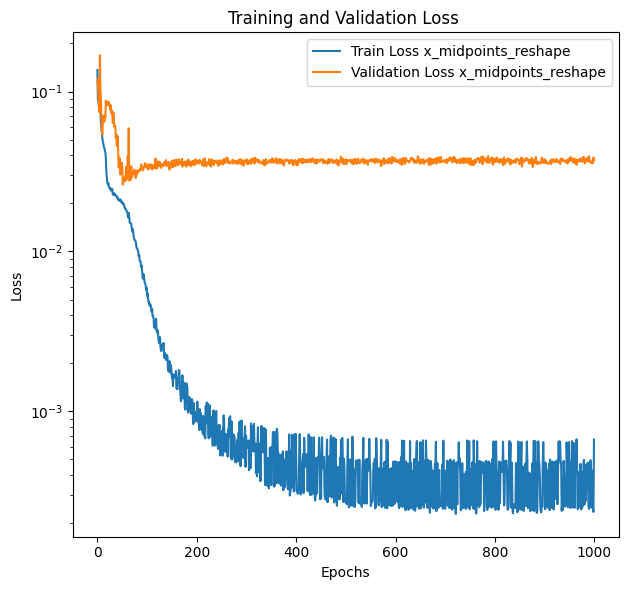

In [34]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
model_builder.model.save("/home/da886/Analysis/12KFixed_Mixed_4_32by32_SparsespotsRandomIndex.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions =model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


W0000 00:00:1729532936.127457   21423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.128275   21419 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.128374   21423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.128404   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.129497   21419 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.129551   21423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.129594   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.130408   21423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.130466   21413 gp

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   

W0000 00:00:1729532936.329167   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.330057   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.330408   21419 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.331036   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.332436   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.333299   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.334247   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.336376   21413 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729532936.349057   21423 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [20]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 4, 2), (9600, 1, 4, 2))

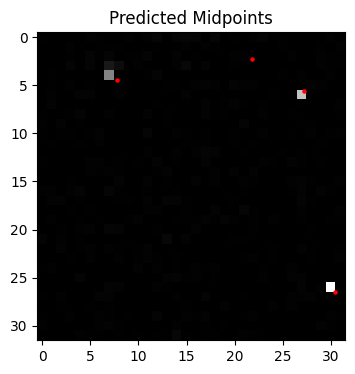

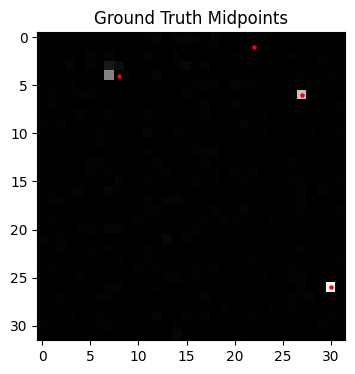

In [48]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [30]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(-160.59007, 303.0473)

In [31]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 63.0)

In [32]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 63.0)

In [34]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[37.49769  ,  0.893701 ],
         [ 5.268126 ,  2.3811095],
         [ 6.2055097,  9.41111  ],
         [38.5479   , 14.923272 ],
         [ 1.6805356, 27.386879 ],
         [45.822754 , 30.42933  ],
         [27.461199 , 36.76014  ],
         [39.048737 , 38.981136 ],
         [13.185979 , 48.234604 ],
         [38.724014 , 50.478184 ],
         [ 5.041256 , 56.032772 ],
         [27.951286 , 54.13892  ],
         [28.76817  , 58.81217  ]]], dtype=float32),
 array([[[37.,  1.],
         [ 6.,  3.],
         [ 5., 11.],
         [38., 13.],
         [ 1., 30.],
         [46., 33.],
         [28., 34.],
         [38., 38.],
         [14., 48.],
         [38., 50.],
         [ 5., 57.],
         [28., 57.],
         [29., 59.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

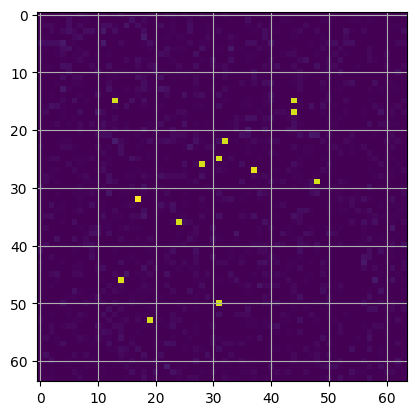

In [32]:
plt.imshow(images[2],)
plt.grid(True)

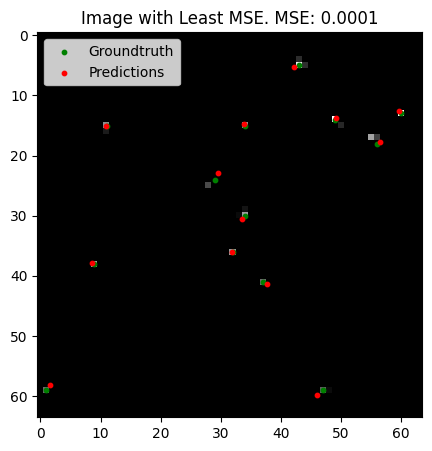

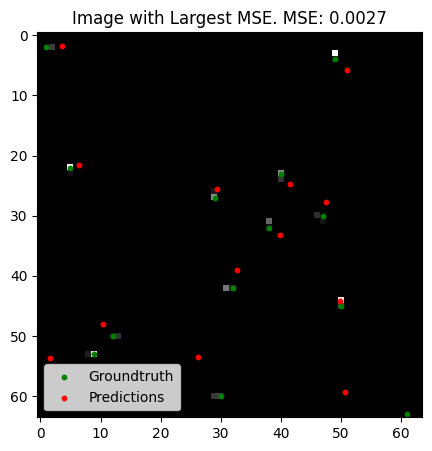

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266